In [1]:
import os, sys
from functools import partial
import numpy as np
from scipy.constants import c
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('../garfield/')
from Genetic_algorithm import *
from Minimization_functions import *
from Resonator_formula import *
from framework import GeneticAlgorithm
from scipy.signal import find_peaks

%matplotlib ipympl

In [25]:
# Importing impedance data
data_impedance = np.loadtxt('/home/malthera/cernbox/Documents/GARFIELD testing/COUPLER/5FerritesCouplerNoOff.txt', comments='#', delimiter='\t')

# Frequency

freq_data = data_impedance[:,0]*1e9

# Impedance

imp_data = data_impedance[:,1]

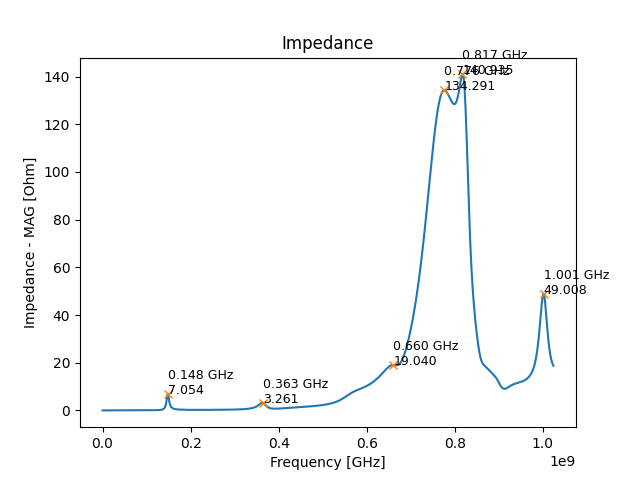

In [63]:
plt.figure()

peaks, properties = find_peaks(imp_data, height=2,prominence=0.1, threshold=None)
for i, (peak, height) in enumerate(zip(peaks, properties['peak_heights'])):
    plt.text(freq_data[peak], imp_data[peak], f'{freq_data[peak]/1e9:.3f} GHz\n{height:.3f}', fontsize=9)

plt.plot(freq_data, imp_data)
plt.plot(freq_data[peaks], (imp_data[peaks]), "x")

plt.xlabel('Frequency [GHz]')
plt.ylabel('Impedance - MAG [Ohm]')
plt.title('Impedance')

plt.show()

In [58]:
properties

{'peak_heights': array([  7.05413353,   3.26117348,  19.04018605, 134.29148967,
        140.9346543 ,  49.00825341]),
 'prominences': array([6.83462188e+00, 2.52989472e+00, 1.23956260e-01, 5.80502638e+00,
        1.31876028e+02, 3.03130223e+01]),
 'left_bases': array([  0, 210,   0,   0,   0, 892]),
 'right_bases': array([ 210,  382,  652,  780,  892, 1000])}

In [84]:
#Number of resonators
Nres = 6 # can be changed to see what happens

#wake_length = 100 # simulated wake length in [m], can be 10,200, 1000, 2000, 4000
frequency_data = freq_data #frequencies in Hz
impedance_data = np.array(data_impedance[:,1])# + \
                          #1j*data_impedance[:,2])

time_data = np.zeros(1)
wake_data = np.zeros(1)
#supply the wake length to the resonator formula to use the 
#partially decayed wake variant 

n_Resonator_longitudinal_imp = partial(n_Resonator_longitudinal_imp)

parameterBounds = [(1, 200), (1,50), (0.145e9, 0.152e9),
                    (1, 200), (1,50), (0.355e9, 0.375e9),
                    (1, 200), (1,50), (0.65e9, 0.67e9),
                    (10, 200), (1,50), (0.765e9, 0.777e9),
                    (10, 200), (1,50), (0.816e9, 0.8175e9),
                    (10, 200), (1,50), (0.99, 1.01e9)]
 # Bounds: [(Rs_min, Rs_max), (Q_min, Q_max), (fres_min, fres_max)].


### Running the GA

In [85]:
%%time
GA_model_scipy_1 = GeneticAlgorithm(frequency_data, 
                                  impedance_data, 
                                  time_data, 
                                  wake_data, 
                                  N_resonators=Nres,
                                  parameterBounds=parameterBounds,
                                  minimizationFunction=sumOfSquaredErrorReal, #sumOfSquaredErrorReal else...
                                  fitFunction=n_Resonator_longitudinal_imp,
                                 )

GA_model_scipy_1.run_geneticAlgorithm(maxiter=30000,
                                    popsize=25, 
                                    tol=0.0001, 
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5
                                   )
print(GA_model_scipy_1.warning)

Progress: [####################] 100% 


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.01e+00        |      22.16       |    1.483e+08     
    2     |        2.89e+00        |      24.42       |    3.614e+08     
    3     |        6.46e+00        |       4.68       |    6.500e+08     
    4     |        1.29e+02        |       9.98       |    7.689e+08     
    5     |        9.23e+01        |      28.53       |    8.165e+08     
    6     |        4.29e+01        |      38.25       |    1.001e+09     
----------------------------------------------------------------------
Optimization terminated successfully.
CPU times: user 6.78 s, sys: 578 ms, total: 7.36 s
Wall time: 9.55 s


In [86]:
%%time
GA_model_scipy_1.run_minimizationAlgorithm(margin=0.5)

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        7.05e+00        |      21.91       |    1.483e+08     
    2     |        2.75e+00        |      23.40       |    3.617e+08     
    3     |        6.48e+00        |       5.77       |    6.284e+08     
    4     |        1.30e+02        |       9.81       |    7.687e+08     
    5     |        9.18e+01        |      28.67       |    8.165e+08     
    6     |        4.30e+01        |      38.42       |    1.001e+09     
----------------------------------------------------------------------
CPU times: user 490 ms, sys: 3.57 ms, total: 494 ms
Wall time: 494 ms


8.21082833402705


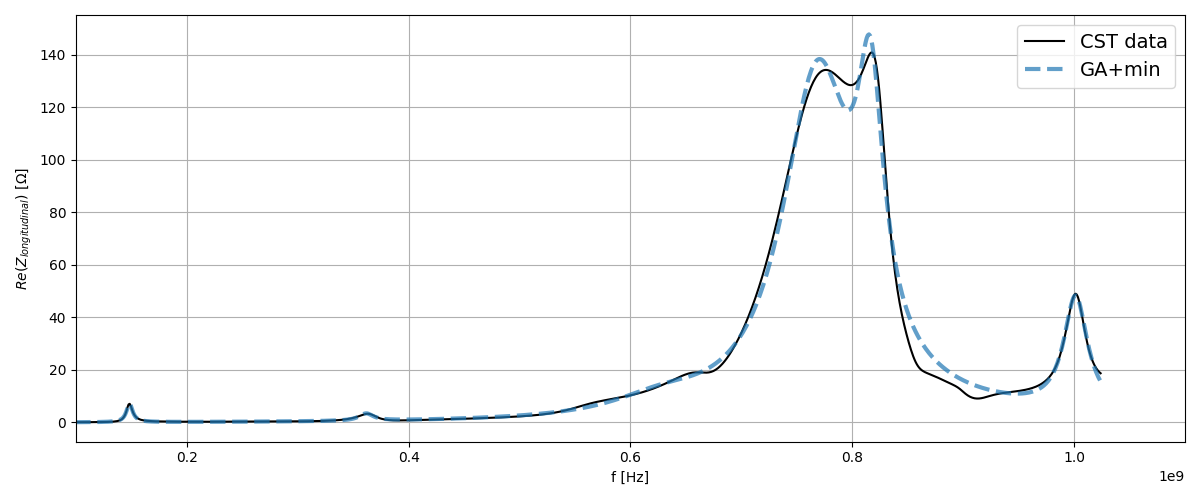

In [91]:
#Plot real part of impedance
fig, ax0 = plt.subplots(1, 1, figsize=(12,5))

#ax0.plot(GA_model_scipy_1.frequency_data, np.abs(data_impedance[:,1] + 1j*data_impedance[:,2]), "grey", label='CST data MAG')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.impedance_data.real, "black", label='CST data')

ax0.plot(GA_model_scipy_1.frequency_data, GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.minimizationParameters.reshape(-1, 3)))).real,
         lw = 3, linestyle='--', label='GA+min', alpha=0.7)

ax0.set_xlabel('f [Hz]')
ax0.set_ylabel('$Re(Z_{longitudinal})$ [$\Omega$]')
ax0.legend(loc='best', fontsize=14)

ax0.set_xlim(0.1e9, 1.1e9)

ax0.grid()

fig.tight_layout()

print(np.mean((np.abs(imp_data) - (GA_model_scipy_1.fitFunction(GA_model_scipy_1.frequency_data, dict(enumerate(GA_model_scipy_1.geneticParameters.reshape(-1, 3)))).real))**2))